<a href="https://colab.research.google.com/github/divy042000/Machine-Learning/blob/main/TOC_AU2140080.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip import graphviz

ERROR: unknown command "import"



NFA for Example 1:


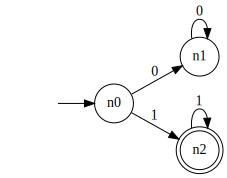


Paths:
n0 --(0)--> n1
n0 --(1)--> n2
n1 --(0)--> n1
n2 --(1)--> n2

DFA for Example 1:


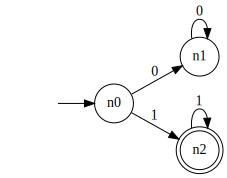


Paths:
n0 --(0)--> n1
n0 --(1)--> n2
n1 --(0)--> n1
n2 --(1)--> n2

Minimized DFA for Example 1:


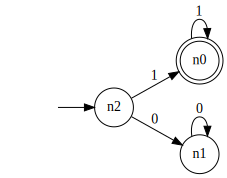


Paths:
n0 --(1)--> n0
n1 --(0)--> n1
n2 --(0)--> n1
n2 --(1)--> n0

NFA for Example 2:


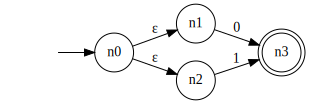


Paths:
n0 --()--> n1, n2
n1 --(0)--> n3
n2 --(1)--> n3

DFA for Example 2:


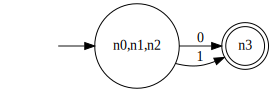


Paths:
n0,n1,n2 --(0)--> n3
n0,n1,n2 --(1)--> n3

Minimized DFA for Example 2:


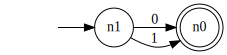


Paths:
n1 --(0)--> n0
n1 --(1)--> n0

NFA:


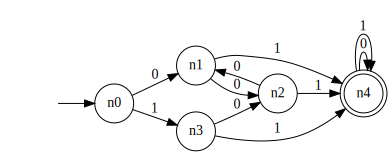


Paths:
n0 --(0)--> n1
n0 --(1)--> n3
n1 --(0)--> n2
n1 --(1)--> n4
n2 --(0)--> n1
n2 --(1)--> n4
n3 --(0)--> n2
n3 --(1)--> n4
n4 --(0)--> n4
n4 --(1)--> n4
NFA created and displayed.

DFA:


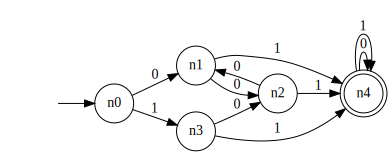


Paths:
n0 --(0)--> n1
n0 --(1)--> n3
n1 --(0)--> n2
n1 --(1)--> n4
n3 --(0)--> n2
n3 --(1)--> n4
n2 --(0)--> n1
n2 --(1)--> n4
n4 --(0)--> n4
n4 --(1)--> n4
DFA created and displayed.

Minimized DFA:


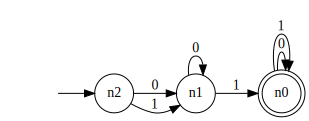


Paths:
n0 --(0)--> n0
n0 --(1)--> n0
n1 --(0)--> n1
n1 --(1)--> n0
n2 --(0)--> n1
n2 --(1)--> n1
Minimized DFA created and displayed.


In [2]:
from graphviz import Digraph
from IPython.display import display

class StateMachine:
    def __init__(self):
        self.nodes = []
        self.symbols = []
        self.paths = {}
        self.initial_node = None
        self.terminal_nodes = []
        self.node_labels = {}  # Renamed from state_names to node_labels

    def create_path(self, start_node, input_symbol, end_nodes):
        if start_node not in self.paths:
            self.paths[start_node] = {}
        if input_symbol not in self.paths[start_node]:
            self.paths[start_node][input_symbol] = set()
        self.paths[start_node][input_symbol].update(end_nodes)

    def closure(self, node_set):
        stack = list(node_set)
        epsilon_closure = set(node_set)
        while stack:
            current_node = stack.pop()
            if current_node in self.paths and '' in self.paths[current_node]:
                for next_node in self.paths[current_node]['']:
                    if next_node not in epsilon_closure:
                        epsilon_closure.add(next_node)
                        stack.append(next_node)
        return frozenset(epsilon_closure)

    def convert_to_dfa(self):
        dfa = StateMachine()
        dfa.symbols = [symbol for symbol in self.symbols if symbol != '']

        initial_node = self.closure({self.initial_node})
        dfa_nodes = [initial_node]
        dfa.initial_node = initial_node
        unprocessed = [initial_node]

        # Create descriptive node names for DFA
        dfa.node_labels[initial_node] = ','.join(sorted(node for node in initial_node))

        while unprocessed:
            current_node = unprocessed.pop(0)
            for input_symbol in dfa.symbols:
                next_node = frozenset()
                for node in current_node:
                    if node in self.paths and input_symbol in self.paths[node]:
                        next_node |= self.paths[node][input_symbol]
                next_node = self.closure(next_node)
                if next_node:
                    dfa.create_path(current_node, input_symbol, {next_node})
                    if next_node not in dfa_nodes:
                        dfa_nodes.append(next_node)
                        unprocessed.append(next_node)
                        dfa.node_labels[next_node] = ','.join(sorted(node for node in next_node))

        dfa.nodes = dfa_nodes
        dfa.terminal_nodes = [node for node in dfa_nodes if any(n in self.terminal_nodes for n in node)]
        return dfa

    def minimize(self):
        # Step 1: Divide nodes into terminal and non-terminal nodes
        initial_partition = [set(self.terminal_nodes), set(self.nodes) - set(self.terminal_nodes)]
        partitions = [initial_partition]

        while True:
            current_partition = partitions[-1]
            new_partition = []

            for group in current_partition:
                subgroups = {}
                for node in group:
                    key = tuple(self.get_group(node, symbol, current_partition) for symbol in self.symbols)
                    if key not in subgroups:
                        subgroups[key] = set()
                    subgroups[key].add(node)
                new_partition.extend(subgroups.values())

            if new_partition == current_partition:
                break
            partitions.append(new_partition)

        # Create the minimized DFA
        minimized_dfa = StateMachine()
        minimized_dfa.symbols = self.symbols[:]

        # Create new nodes
        node_mapping = {}
        for i, group in enumerate(new_partition):
            new_node = frozenset(group)
            minimized_dfa.nodes.append(new_node)
            minimized_dfa.node_labels[new_node] = f"n{i}"  # Using 'n' for nodes
            for old_node in group:
                node_mapping[old_node] = new_node
            if self.initial_node in group:
                minimized_dfa.initial_node = new_node
            if any(node in self.terminal_nodes for node in group):
                minimized_dfa.terminal_nodes.append(new_node)

        # Create new paths
        for group in new_partition:
            old_node = next(iter(group))  # Pick any node from the group
            new_node = node_mapping[old_node]
            for input_symbol in self.symbols:
                if old_node in self.paths and input_symbol in self.paths[old_node]:
                    old_next_node = next(iter(self.paths[old_node][input_symbol]))
                    new_next_node = node_mapping[old_next_node]
                    minimized_dfa.create_path(new_node, input_symbol, {new_next_node})

        return minimized_dfa

    def get_group(self, node, symbol, partition):
        if node in self.paths and symbol in self.paths[node]:
            next_node = next(iter(self.paths[node][symbol]))
            for i, group in enumerate(partition):
                if next_node in group:
                    return i
        return -1

    def display(self, diagram_title):
        dot = Digraph(comment='State Machine')
        dot.attr(rankdir='LR')

        # Add nodes
        for node in self.nodes:
            if node in self.terminal_nodes:
                dot.attr('node', shape='doublecircle')
            else:
                dot.attr('node', shape='circle')
            node_label = self.node_labels.get(node, str(node))
            dot.node(str(node), node_label)

        # Add start node
        dot.attr('node', shape='none')
        dot.edge('', str(self.initial_node))

        # Add paths
        for start_node, transitions in self.paths.items():
            for input_symbol, end_nodes in transitions.items():
                for end_node in end_nodes:
                    dot.edge(str(start_node), str(end_node), label=input_symbol if input_symbol != '' else 'ε')

        print(f"\n{diagram_title}:")
        display(dot)

    def readable_paths(self):
        print("\nPaths:")
        for start_node, transitions in self.paths.items():
            start_name = self.node_labels.get(start_node, str(start_node))
            for input_symbol, end_nodes in transitions.items():
                end_names = [self.node_labels.get(node, str(node)) for node in end_nodes]
                print(f"{start_name} --({input_symbol})--> {', '.join(end_names)}")



# NFA: Accepts strings where either '0' or '1' leads to an accept state.

nfa1 = StateMachine()
nfa1.nodes = ['n0', 'n1', 'n2']
nfa1.symbols = ['0', '1']
nfa1.initial_node = 'n0'
nfa1.terminal_nodes = ['n2']
nfa1.node_labels = {node: node for node in nfa1.nodes}

nfa1.create_path('n0', '0', {'n1'})
nfa1.create_path('n0', '1', {'n2'})
nfa1.create_path('n1', '0', {'n1'})  # Self-loop on n1 for '0'
nfa1.create_path('n2', '1', {'n2'})  # Self-loop on n2 for '1'

nfa1.display('NFA for Example 1')
nfa1.readable_paths()

dfa1 = nfa1.convert_to_dfa()
dfa1.display('DFA for Example 1')
dfa1.readable_paths()

minimized_dfa1 = dfa1.minimize()
minimized_dfa1.display('Minimized DFA for Example 1')
minimized_dfa1.readable_paths()

# NFA: Contains epsilon transitions (ε) leading to different states.

nfa2 = StateMachine()
nfa2.nodes = ['n0', 'n1', 'n2', 'n3']
nfa2.symbols = ['0', '1', '']
nfa2.initial_node = 'n0'
nfa2.terminal_nodes = ['n3']
nfa2.node_labels = {node: node for node in nfa2.nodes}

nfa2.create_path('n0', '', {'n1', 'n2'})  # ε-transition from n0 to n1 and n2
nfa2.create_path('n1', '0', {'n3'})
nfa2.create_path('n2', '1', {'n3'})

nfa2.display('NFA for Example 2')
nfa2.readable_paths()

dfa2 = nfa2.convert_to_dfa()
dfa2.display('DFA for Example 2')
dfa2.readable_paths()

minimized_dfa2 = dfa2.minimize()
minimized_dfa2.display('Minimized DFA for Example 2')
minimized_dfa2.readable_paths()



# Example usage
nfa = StateMachine()
nfa.nodes = ['n0', 'n1', 'n2', 'n3', 'n4']
nfa.symbols = ['0', '1']
nfa.initial_node = 'n0'
nfa.terminal_nodes = ['n4']
nfa.node_labels = {node: node for node in nfa.nodes}

nfa.create_path('n0', '0', {'n1'})
nfa.create_path('n0', '1', {'n3'})
nfa.create_path('n1', '0', {'n2'})
nfa.create_path('n1', '1', {'n4'})
nfa.create_path('n2', '0', {'n1'})
nfa.create_path('n2', '1', {'n4'})
nfa.create_path('n3', '0', {'n2'})
nfa.create_path('n3', '1', {'n4'})
nfa.create_path('n4', '0', {'n4'})
nfa.create_path('n4', '1', {'n4'})

nfa.display('NFA')
nfa.readable_paths()
print("NFA created and displayed.")

dfa = nfa.convert_to_dfa()
dfa.display('DFA')
dfa.readable_paths()
print("DFA created and displayed.")

minimized_dfa = dfa.minimize()
minimized_dfa.display('Minimized DFA')
minimized_dfa.readable_paths()
print("Minimized DFA created and displayed.")
